# Assignment 3

In this analysis five different datasets are selected from http://www.timeseriesclassification.com/. Several models are trained for each dataset. Two different representations each with two different parameter sets are used to build the model. Then, distances between the time series are calculated using 4 different distance measures. In the classification step, 3 different k values are used in the K-NN algorithm. Accuracy of each model is calculated to determine the best performing model. Finally, the best performing model is tested on a seperate test set.

In [ ]:
library(data.table)
library(ggplot2)
library(TSrepr)
library(caret)
library(TSdist)
library(dtw)
library(zoo)
library(rpart)
library(rattle)
require(TunePareto)

setwd("C:/Users/alpsr/Desktop/Assignment 3")

## Dataset 4: SmoothSubspace

In this notebook, Plane dataset is evaluated. This dataset contains 150 training time series and 150 test time series. There are 3 different classes. First six time series in the training dataset are as follows.

In [2]:
dataset = 'SmoothSubspace'
train_data_path=sprintf('%s/%s/%s_TRAIN.txt',getwd(),dataset,dataset)

In [3]:
sub = fread(train_data_path)
sub <- setnames(sub, "V1", "Class")
sub <- data.table(sub)
sub[, "ID" := 1:.N]
sub[, "Class" := as.factor(Class)]
setcolorder(sub, c("ID", "Class"))
colnames(sub) <- c("ID", "Class",seq(1:15))
sub_matrix <- as.matrix(sub[,c(-1,-2)])
sub_long <- melt(sub,id.vars = c("ID","Class"))
sub_long[,variable := as.numeric(variable)]
sub_class <- sub$Class
head(sub)

ID,Class,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.4810517,0.6145143,0.6183783,0.4971101,0.6595241,0.8790139,0.6628081,0.3288142,0.4023883,0.38724543,0.04265986,0.04229780,0.41704745,0.42791092,0.42485841
2,1,0.5175792,0.6477515,0.7577292,0.5509700,0.5986248,0.3185243,0.3985895,0.1278884,0.7032232,0.81614010,0.99615611,0.24090500,0.93713467,0.43618496,0.57892349
3,1,0.4174242,0.6100467,0.7901224,0.5250664,0.5976593,0.4424023,0.1925104,0.1966582,0.7580993,0.09851874,0.53566419,0.39000491,0.07068434,0.67477647,0.05597616
4,1,0.6322746,0.6261523,0.7710858,0.4517133,0.6186154,0.5605595,0.8541000,0.1320830,0.1704320,0.35507365,0.69378761,0.48959434,0.66693153,0.61280959,0.26013019
5,1,0.4941312,0.6011924,0.7280025,0.4112070,0.5811399,0.7487057,0.7855590,0.6078659,0.2175633,0.64206083,0.51181992,0.04755467,0.64630196,0.07103708,0.68006553
6,1,0.5128905,0.5825645,0.7455101,0.4872114,0.6074090,0.5340641,0.1339313,0.5495401,0.5557379,0.31742786,0.35453430,0.71504501,0.82953282,0.82662951,0.86688705


## Classes

Three classes from the dataset are as follows.

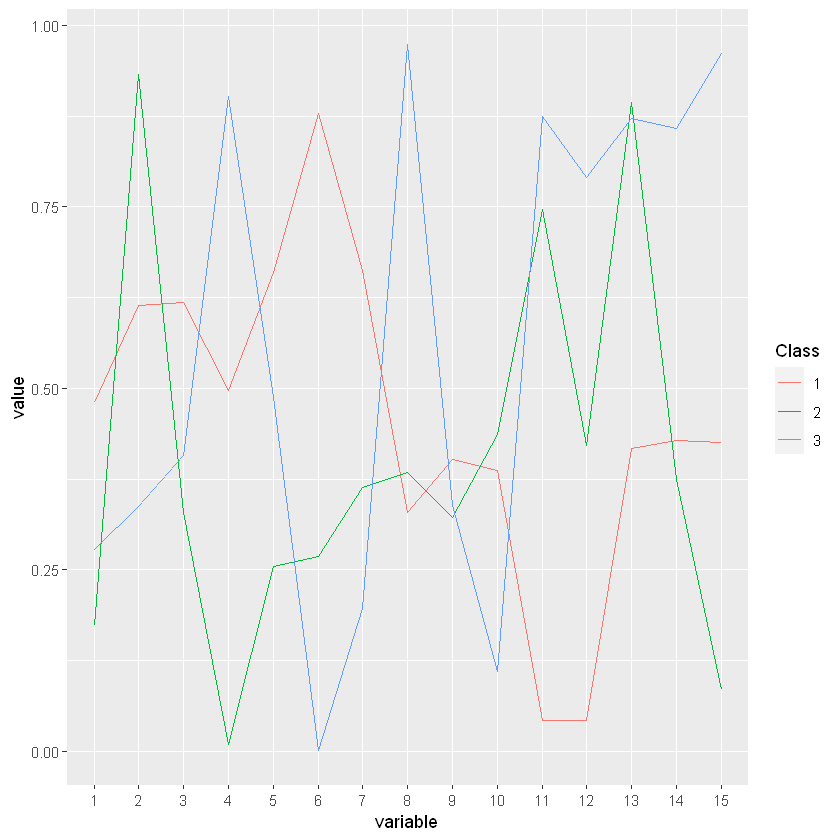

In [4]:
sub_class_1 <- melt(sub[,head(.SD, 1), Class],id.vars = c("ID","Class"))

ggplot(sub_class_1, aes(x = variable, y = value, group = Class)) +
geom_line(aes(color = Class))

## Representations

Two different representations are used in this analysis. First one is PLA (piecewise linear approximation) and second is the APCA (Adaptive Piecewise Constant Approximation) using regression trees.

### Piecewise Linear Approximation

In [5]:
sub_pla_q12 <- repr_matrix(sub_matrix,repr_pla,args = list(times = 5, return = 'points'))
sub_pla_q6 <- repr_matrix(sub_matrix,repr_pla,args = list(times = 3,return = 'points'))

index1 = c(seq(1,14, by = 3),15)
for(i in seq(1,150)){
    sub_long[(variable %in% index1) & (ID == i), PLA_q12 := sub_pla_q12[i,]]
    sub_long[ID == i, PLA_q12_fit_value := sub_long[ID == i, na.approx(PLA_q12)]]
}

index2 = c(seq(1,14, by = 5),15)
for(i in seq(1,150)){
    sub_long[(variable %in% index2) & (ID == i), PLA_q6 := sub_pla_q6[i,]]
    sub_long[ID == i, PLA_q6_fit_value := sub_long[ID == i, na.approx(PLA_q6)]]
}

### Regression Trees

In [6]:
for(i in seq(1,150)){
    selected_series <- sub_long[ID == i]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=3, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    sub_long[ID == i, Tree_fit_d3 := predict(tree_fit, selected_series)]
}

for(j in seq(1,150)){
    selected_series <- sub_long[ID == j]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=4, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    sub_long[ID == j, Tree_fit_d4 := predict(tree_fit, selected_series)]
}

head(sub_long)

ID,Class,variable,value,PLA_q12,PLA_q12_fit_value,PLA_q6,PLA_q6_fit_value,Tree_fit_d3,Tree_fit_d4
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0.4810517,0.4810517,0.4810517,0.4810517,0.4810517,0.4590415,0.4590415
2,1,1,0.5175792,0.5175792,0.5175792,0.5175792,0.5175792,0.5750883,0.5750883
3,1,1,0.4174242,0.4174242,0.4174242,0.4174242,0.4174242,0.4237076,0.4237076
4,1,1,0.6322746,0.6322746,0.6322746,0.6322746,0.6322746,0.5263562,0.5263562
5,1,1,0.4941312,0.4941312,0.4941312,0.4941312,0.4941312,0.5182805,0.5182805
6,1,1,0.5128905,0.5128905,0.5128905,0.5128905,0.5128905,0.5745944,0.5745944


## Distance Measures

Three different distances measures are used. First one is the Euclidean Distance. Remaining ones are Dynamic Time Warping (DTW), Longest Common Subsequence (LCSS) and Edit Distance with Real Penalties (ERP).

### Euclidean Distance

In [7]:
sub_euclidean_raw <- as.matrix(dist(sub_matrix))

sub_PLA_q12_matrix <- dcast(sub_long, ID + Class ~ variable, value.var = "PLA_q12_fit_value")
sub_PLA_q6_matrix <- dcast(sub_long, ID + Class ~ variable, value.var = "PLA_q6_fit_value")
sub_RegTree_d3_matrix <- dcast(sub_long, ID + Class ~ variable, value.var = "Tree_fit_d3")
sub_RegTree_d4_matrix <- dcast(sub_long, ID + Class ~ variable, value.var = "Tree_fit_d4")

sub_euclidean_pla_q12 <- as.matrix(dist(as.matrix(sub_PLA_q12_matrix[,c(-1,-2)])))
sub_euclidean_pla_q6 <- as.matrix(dist(as.matrix(sub_PLA_q6_matrix[,c(-1,-2)])))
sub_euclidean_RegTree_d3 <- as.matrix(dist(as.matrix(sub_RegTree_d3_matrix[,c(-1,-2)])))
sub_euclidean_RegTree_d4 <- as.matrix(dist(as.matrix(sub_RegTree_d4_matrix[,c(-1,-2)])))

### Dynamic Time Warping

In [8]:
sub_dtw_pla_q12 <- as.matrix(TSDatabaseDistances(X = sub_PLA_q12_matrix[,c(-1,-2)], distance = 'dtw'))
sub_dtw_pla_q6 <- as.matrix(TSDatabaseDistances(X = sub_PLA_q6_matrix[,c(-1,-2)], distance = 'dtw'))
sub_dtw_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = sub_RegTree_d3_matrix[,c(-1,-2)], distance = 'dtw'))
sub_dtw_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = sub_RegTree_d4_matrix[,c(-1,-2)], distance = 'dtw'))
sub_dtw_raw <- as.matrix(TSDatabaseDistances(X = sub_matrix, distance = 'dtw'))

### LCSS

In [9]:
sub_lcss_raw <- as.matrix(TSDatabaseDistances(X = sub_matrix, distance = 'lcss', epsilon = 0.1))
sub_lcss_pla_q12 <- as.matrix(TSDatabaseDistances(X = sub_PLA_q12_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
sub_lcss_pla_q6 <- as.matrix(TSDatabaseDistances(X = sub_PLA_q6_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
sub_lcss_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = sub_RegTree_d3_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
sub_lcss_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = sub_RegTree_d4_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
#str(sub_lcss_pla_q12)

### ERP

In [10]:
sub_erp_raw <- as.matrix(TSDatabaseDistances(X = sub_matrix, distance = 'erp', g = 0))
sub_erp_pla_q12 <- as.matrix(TSDatabaseDistances(X = sub_PLA_q12_matrix[,c(-1,-2)], distance = 'erp', g = 0))
sub_erp_pla_q6 <- as.matrix(TSDatabaseDistances(X = sub_PLA_q6_matrix[,c(-1,-2)], distance = 'erp', g = 0))
sub_erp_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = sub_RegTree_d3_matrix[,c(-1,-2)], distance = 'erp', g = 0))
sub_erp_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = sub_RegTree_d4_matrix[,c(-1,-2)], distance = 'erp', g = 0))
#str(sub_erp_pla_q12)

## Generating Runs

After building the distance matrices, each model's performance is measured using the 10-fold stratified cross validation with 5 repeats.

### Cross-Validation Runs

In [11]:
set.seed(12435)
cv_indices = generateCVRuns(sub_class, ntimes = 5, nfold = 10, 
                            leaveOneOut = FALSE, stratified = TRUE)
str(cv_indices)

List of 5
 $ Run  1:List of 10
  ..$ Fold  1 : int [1:15] 24 50 36 38 34 57 92 85 64 74 ...
  ..$ Fold  2 : int [1:15] 17 45 13 23 32 94 63 61 100 73 ...
  ..$ Fold  3 : int [1:15] 1 19 15 46 28 90 95 84 99 76 ...
  ..$ Fold  4 : int [1:15] 6 43 31 26 21 54 89 97 72 70 ...
  ..$ Fold  5 : int [1:15] 29 8 48 33 9 58 93 88 79 87 ...
  ..$ Fold  6 : int [1:15] 41 39 18 20 12 60 77 81 52 65 ...
  ..$ Fold  7 : int [1:15] 10 47 42 25 3 71 96 80 82 68 ...
  ..$ Fold  8 : int [1:15] 16 4 44 27 14 91 86 67 56 98 ...
  ..$ Fold  9 : int [1:15] 30 37 2 49 11 62 66 55 69 51 ...
  ..$ Fold  10: int [1:15] 40 7 5 22 35 53 59 75 83 78 ...
 $ Run  2:List of 10
  ..$ Fold  1 : int [1:15] 13 17 1 23 27 69 97 64 93 83 ...
  ..$ Fold  2 : int [1:15] 29 26 46 2 24 91 95 86 81 80 ...
  ..$ Fold  3 : int [1:15] 4 7 22 41 30 73 60 75 96 63 ...
  ..$ Fold  4 : int [1:15] 33 32 11 16 25 76 98 62 79 51 ...
  ..$ Fold  5 : int [1:15] 9 21 49 18 31 54 61 67 66 87 ...
  ..$ Fold  6 : int [1:15] 34 28 40 47 45 70 5

### k-NN Classifier

In [12]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    ordered_indices=apply(test_distances_to_train,1,order)
    
    if(k==1){
        nearest_class=as.numeric(train_class[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {train_class[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

### Testing the Models

In [13]:
#approach_file=list.files(dist_folder)
dist = list(sub_euclidean_raw,
            sub_euclidean_pla_q12,
            sub_euclidean_pla_q6,
            sub_euclidean_RegTree_d3,
            sub_euclidean_RegTree_d4,
            sub_dtw_raw,
            sub_dtw_pla_q12,
            sub_dtw_pla_q6,
            sub_dtw_RegTree_d3,
            sub_dtw_RegTree_d4,
            sub_lcss_raw,
            sub_lcss_pla_q6,
            sub_lcss_pla_q12,
            sub_lcss_RegTree_d3,
            sub_lcss_RegTree_d4,
            sub_erp_raw,
            sub_erp_pla_q6,
            sub_erp_pla_q12,
            sub_erp_RegTree_d3,
            sub_erp_RegTree_d4)

n_dist = 15
nof_rep = 5
n_fold = 10
k_levels=c(1,5,10)
result = vector('list',n_dist*nof_rep*n_fold*length(k_levels))
iter = 1
names = c("sub_euclidean_raw","sub_euclidean_pla_q12","sub_euclidean_pla_q6",
         "sub_euclidean_RegTree_d3","sub_euclidean_RegTree_d4",
         "sub_dtw_raw","sub_dtw_pla_q12","sub_dtw_pla_q6","sub_dtw_RegTree_d3",
         "sub_dtw_RegTree_d4","sub_lcss_raw","sub_lcss_pla_q6","sub_lcss_pla_q12",
         "sub_lcss_RegTree_d3","sub_lcss_RegTree_d4","sub_erp_raw","sub_erp_pla_q6",
         "sub_erp_pla_q12","sub_erp_RegTree_d3","sub_erp_RegTree_d4")

In [14]:
CrossValidationTrain <- function(dist,cv_index, train_class){
    n_dist = 20
    nof_rep = 5
    n_fold = 10
    k_levels=c(1,3,5)

    for(m in 1:n_dist){ #
        current_dist = dist[[m]]
        for(i in 1:nof_rep){
            this_fold=cv_index[[i]]
            for(j in 1:n_fold){
                test_indices=this_fold[[j]]
                for(k in 1:length(k_levels)){
                    current_k=k_levels[k]
                    current_fold=nn_classify_cv(current_dist,train_class,test_indices,k=current_k)
                    accuracy=sum(train_class[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                    tmp=data.table(approach=names[[m]],repid=i,foldid=j,
                                   k=current_k,acc=accuracy)
                    
                    result[[iter]]=tmp
                    iter=iter+1
                }
            }
        }   
    }
    return(result)
}

Mean and standart deviation of each model is reported below. There are two best performing methods. ERP distance on the raw time series when k = 1 and k = 3 are thw best performing methods. Their mean accuracy is 99.47%. For the final testing ERP on the raw time series with 1-NN classifier will be used

In [15]:
result_sub = CrossValidationTrain(dist,cv_indices, sub_class)
result_sub = rbindlist(result_sub)

results_summary <- result_sub[,.(Mean = mean(acc),SD = sd(acc)),.(approach,k)]
results_summary[order(-Mean)]

approach,k,Mean,SD
<chr>,<dbl>,<dbl>,<dbl>
sub_erp_raw,1,0.994666667,0.01826983
sub_erp_raw,3,0.994666667,0.01826983
sub_erp_raw,5,0.990666667,0.02697105
sub_dtw_raw,5,0.944000000,0.05278631
sub_euclidean_raw,5,0.941333333,0.06951729
sub_dtw_raw,3,0.917333333,0.06941283
sub_euclidean_raw,3,0.917333333,0.07197883
sub_dtw_raw,1,0.914666667,0.07858153
sub_euclidean_raw,1,0.901333333,0.07029578


## Testing

In [16]:
test_data_path=sprintf('%s/%s/%s_TEST.txt',getwd(),dataset,dataset)

sub_train = fread(train_data_path)
sub_test = fread(test_data_path)

sub_test <- setnames(sub_test, "V1", "Class")
sub_train <- setnames(sub_train, "V1", "Class")

sub_test <- data.table(sub_test)
sub_train <- data.table(sub_train)

sub_test[, "ID" := (1:.N)+150]
sub_test[, "Class" := as.factor(Class)]
sub_train[, "ID" := (1:.N)]
sub_train[, "Class" := as.factor(Class)]

sub_comb <- rbindlist(list(sub_train,sub_test),use.names = TRUE)

setcolorder(sub_comb, c("ID", "Class"))
colnames(sub_comb) <- c("ID", "Class",seq(1:15))
sub_comb_matrix <- as.matrix(sub_comb[,c(-1,-2)])
sub_comb_long <- melt(sub_comb,id.vars = c("ID","Class"))
sub_comb_long[,variable := as.numeric(variable)]
sub_comb_class <- sub_comb$Class

test_index_final = seq(151,300)

sub_comb_euclidean_raw <- as.matrix(dist(as.matrix(sub_comb_matrix)))

overall_result <- nn_classify_cv(sub_comb_euclidean_raw,sub_comb_class,test_index_final,k=3)

Finally, the best performing model is used to classify the test data and its test accuracy is 94.67%

Summary of the best performing model is as follows:

In [18]:
Test_Accuracy <- sum(sub_comb_class[test_index_final]==overall_result$prediction$predicted)/length(test_index_final)
Test_Accuracy

[1] 0.9466667

In [19]:
Dataset <- "SmoothSubspace"
Cross_Validation_Mean_Accuracy <- max(results_summary$Mean)
Distance = 'ERP'
Representation = 'Raw'
K = '1'
df <- data.frame(Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K)
df

Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
SmoothSubspace,0.9946667,0.9466667,ERP,Raw,1
